# Cervejaria Latinhas LLC

Esse projeto foi inspirado na descrição de um [`Processo de produção de cerveja por batelada`](https://brasilescola.uol.com.br/quimica/processo-producao-cerveja.htm).

Para esta simulação iremos utilizar o <span style="color:blue">SimPy</span> que é uma biblioteca de simulação em Python que é usada para modelar e simular sistemas baseados em eventos discretos.

<span style="color:yellow">Atenção: </span> Para instalação use o comando `pip install simpy`


<span style="color:blue">TCLab</span> é uma biblioteca para simulação de controle de temperatura. Ele fornece uma API simples e intuitiva para criar e executar simulações de controle de temperatura.

<span style="color:yellow">Atenção: </span> Para instalação use o comando `pip install tclab`

In [1]:
import simpy
%matplotlib inline

import random
random.seed(55)

import tclab
from tclab import clock, setup, Historian, Plotter

`Função PID:`

In [2]:
def PID(Kp, Ki, Kd, MV_bar=0):
    e_prev = 0
    t_prev = -100
    I = 0

    MV = MV_bar

    while True:
        t, PV, SP = yield MV

        e = SP - PV

        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        D = Kd*(e - e_prev)/(t - t_prev)

        MAX_MV = 100
        MV = MAX_MV if (MV_bar + P + I + D) > MAX_MV else (MV_bar + P + I + D)

        e_prev = e
        t_prev = t

### 1 - Moinho:

O moinho é o equipamento responsável por moer o malte. Existem vários tipos de moinhos disponíveis, como moinhos de martelo, moinhos de rolos e moinhos de disco.

O sistema de moagem irá atuar em recirculação até atingir a granulometria desejada. Para medição da granulometria será empregado o sensor [`MYTA da Bühler AG`](https://www.buhlergroup.com/global/pt/product-families/Online-sensors.html).

<img align="left" src="./Imagens/MYTA_Bühler_AG.png"     style=" width:500px; padding: 10px; " >

In [3]:
def sim_MYTA(env, moinho):
    yield env.timeout(100)
    # Aqui estamos simulando o ponto em que o sensor MYTA irá indicar a granulometria esperada
    # Usamos neste caso como uma função do tempo, mas no caso real, teremos um valor de granulometria que irá influenciar no processo.
    moinho.action.interrupt()


class Moinho(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.moagem())

    def moagem(self):
        while True:
            print('Moinho ligado %d' % self.env.now)
            tempo_de_moagem = 10

            try:
                yield self.env.process(self.aguardar(tempo_de_moagem))
            except simpy.Interrupt:
                print('Granulometria atingiu ponto ideal ...')
                # PARAR AQUI
                return

            print('Atuação do agitador multivibratório %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def aguardar(self, duracao):
        yield self.env.timeout(duracao)


env = simpy.Environment()
moinho = Moinho(env)
env.process(sim_MYTA(env, moinho))
env.run(until=200)

Moinho ligado 0
Atuação do agitador multivibratório 10
Moinho ligado 12
Atuação do agitador multivibratório 22
Moinho ligado 24
Atuação do agitador multivibratório 34
Moinho ligado 36
Atuação do agitador multivibratório 46
Moinho ligado 48
Atuação do agitador multivibratório 58
Moinho ligado 60
Atuação do agitador multivibratório 70
Moinho ligado 72
Atuação do agitador multivibratório 82
Moinho ligado 84
Atuação do agitador multivibratório 94
Moinho ligado 96
Granulometria atingiu ponto ideal ...


### 2 - Brassagem:

A faixa de temperatura ideal para a brassagem varia de acordo com o tipo de cerveja que está sendo produzida. Cervejas leves e claras, como a Pilsen, geralmente são brassadas a temperaturas mais baixas, entre 60 e 68 graus Celsius. Cervejas mais escuras e fortes, como a Stout, geralmente são brassadas a temperaturas mais altas, entre 70 e 78 graus Celsius.

Iremos utilizar um controlador PID. No gráfico da simulação serão apresentados:

`SP: Setpoint`

`T1: Sensor de temperatura do processo de brassagem`

`MV: Variável de manipulação`

`Q1: Fonte de calor. Uma resistência elétrica por exemplo`


<span style="color:yellow">Setpoint de Brassagem será de 70 °C </span>

A faixa de pH ideal para a brassagem também varia de acordo com o tipo de cerveja que está sendo produzida. Cervejas claras e leves geralmente têm um pH mais baixo, entre 5,2 e 5,5. Cervejas mais escuras e fortes geralmente têm um pH mais alto, entre 5,5 e 5,8.

<span style="color:yellow">Setpoint de pH será de 5,5 </span>

<span style="color:orange">Os processos de controle de temperatura e pH ocorrerão de forma paralela.</span>

`A densidade será medida após este processo, aguardando um período de 3 horas de descanso para depois medir a densidade.`

<span style="color:yellow">NOTA:</span> Este resultado irá ser apresentado após o primeiro gráfico.


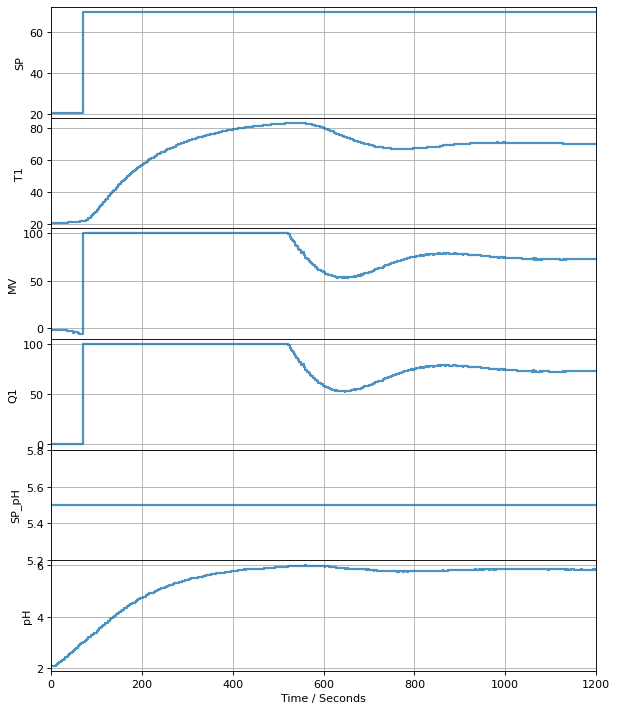

TCLab Model disconnected successfully.
Aguardando 3 horas para medir densidade 0
Densidade do mosto está ideal ...


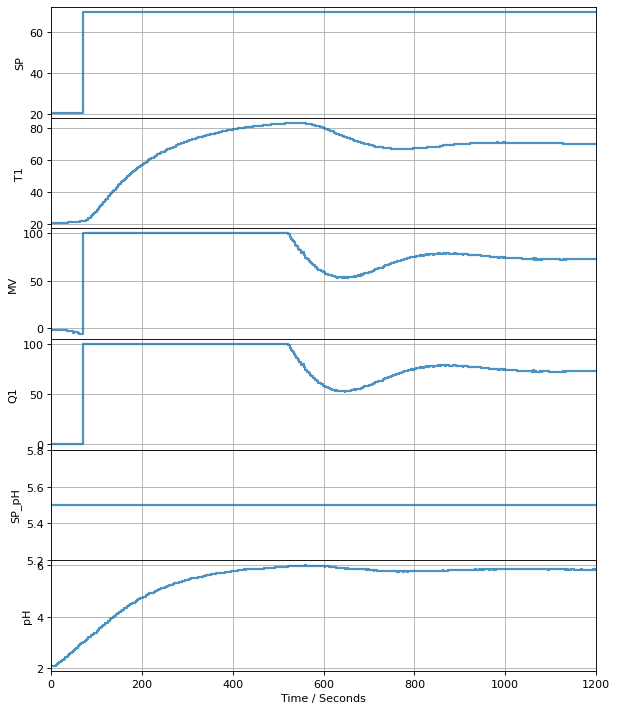

In [4]:
TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP = 70
controllerTEMP = PID(2, 0.05, 2.5)
controllerTEMP.send(None)

# Parâmetros do controle de pH:
# Convenientemente, para fins de simulação iremos empregar o T2 como uma entrada simulada de sensor de pH que já possui uma resposta inercial descrita.
SetPoint_pH = 5.5
controller_pH = PID(1, 0.1, 2.0)
controller_pH.send(None)

# Periodo de simulação:
tfinal = 1200

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: lab.T1), ('MV', lambda: MV_TEMP), ('Q1', lab.Q1),
                   ('SP_pH', lambda: SP_ph/10), ('pH', lambda: lab.T2/10)])

    p = Plotter(h, tfinal)
    T1 = lab.T1
    T2 = lab.T2
    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = T1 if t < SetPointTEMP else SetPointTEMP
        PV_TEMP = lab.T1
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP

        # Controle de pH:
        SP_ph = (SetPoint_pH * 10)
        PV_ph = lab.T2
        MV_ph = controller_pH.send([t, PV_ph, SP_ph])
        lab.U2 = MV_ph

        p.update(t)


# Simulação do densimetro do mosto:

def sim_Densimetro(env, moinho):
    yield env.timeout(20)
    moinho.action.interrupt()


class Densimetro(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.densidade())

    def densidade(self):
        while True:
            print('Aguardando 3 horas para medir densidade %d' % self.env.now)
            tempo_de_descando = 30

            try:
                yield self.env.process(self.aguardar(tempo_de_descando))
            except simpy.Interrupt:
                print('Densidade do mosto está ideal ...')
                # PARAR AQUI
                return

            print('Aguardando %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def aguardar(self, duracao):
        yield self.env.timeout(duracao)


env = simpy.Environment()
dens = Densimetro(env)
env.process(sim_Densimetro(env, dens))
env.run(until=100)

### 3 - Filtragem do mosto:

A filtragem do mosto é realizada para retirar todos os componentes insolúveis presentes na mistura, durante aproximadamente três horas. O filtrado é o mosto, e o material retido no filtro pode ser utilizado como alimento para o gado.


In [5]:
env = simpy.Environment()
dens = Densimetro(env)
env.process(sim_Densimetro(env, dens))
env.run(until=100)


Aguardando 3 horas para medir densidade 0
Densidade do mosto está ideal ...


### 4 - Ebulição do mosto:

Após o processo de filtração, o lúpulo é adicionado ao mosto, e logo em seguida, a mistura é submetida ao processo de ebulição (aquecimento) por um período de duas horas. Durante o aquecimento do mosto misturado ao lúpulo, ocorre a esterilização da mistura e a liberação de componentes voláteis indesejáveis, bem como substâncias que agregam um melhor sabor à cerveja.

`Para fins de simulação, iremos corrigir a temperatura para atingir os 100C devido as limitações de configuração do modelo físico do TCLab.`

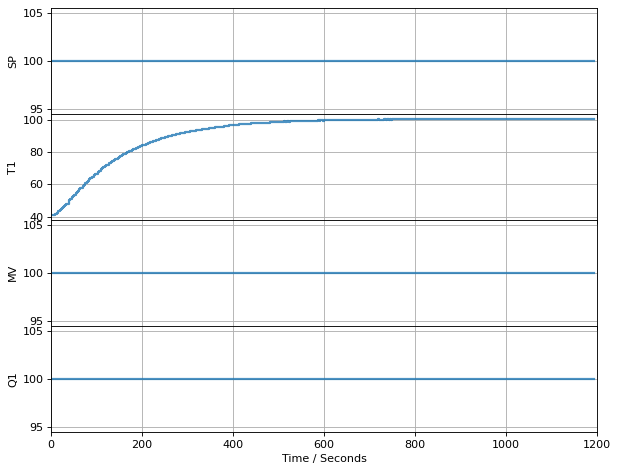

TCLab Model disconnected successfully.

O Lúpulo foi adicionado previamente. O processo foi mantido por 2 horas.



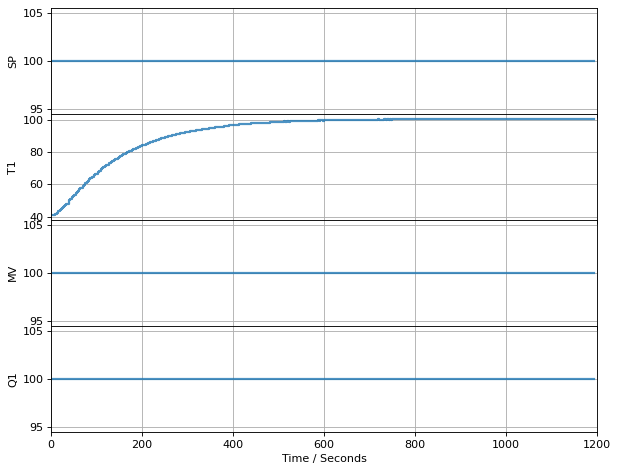

In [6]:
# Adição do lúpulo:
print('\nAdição do Lúpulo\n')

#########################################################

TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP = 100
controllerTEMP = PID(2, 1.5, 2.5)
controllerTEMP.send(None)

# Periodo de simulação de 2 horas:
tfinal = 1200

lab.U1 = 100

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: PV_TEMP),
                  ('MV', lambda: MV_TEMP), ('Q1', lab.Q1)])

    p = Plotter(h, tfinal)
    T1 = lab.T1

    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = SetPointTEMP
        PV_TEMP = lab.T1 + 20
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP

        p.update(t)


# Adição do prévia do lúpulo:
print('\nO Lúpulo foi adicionado previamente. O processo foi mantido por 2 horas.\n')

### 5 - Resfriamento:

Resfriamento: após a realização da ebulição, o mosto lupulado sofre um resfriamento até uma temperatura de 8 °C a 9 °C.

É recomendado o uso de um sistema [`Chiller`](https://www.maqfriorefrigeracao.com.br/chiller-resfriamento) com [`Propilenoglicol`](https://www.ict.unesp.br/Home/sobreoict/departamentosdeensino/odontologiarestauradora/lipq-laboratoriointegradodepesquisa/propilenoglicol-ilovepdf-compressed.pdf) apropriado para processamento de alimentos e com baixa toxicidade.

Em sistemas Chiller existe uma preocupação de segurança com possível falha que possa causar o congelamento no evaporador e sua consequente destruição, podendo sem um vazamento ou um acidente maior, incluindo contaminação de toda cerveja processada. Para garantir a segurança deste processo é necessária a instalação de um termostato (`precisa ser uma solução eletromecânica para atendimento da ASHRAE`) na saída do evaporador.

Entretando normalmente isso é feito pelo fabricante do [`Chiller`](https://www.maqfriorefrigeracao.com.br/chiller-resfriamento), portanto não fará parte desse projeto.

`Para fins de simulação, iremos corrigir a temperatura para atingir os 0 °C devido as limitações de configuração do modelo físico do TCLab.`

<span style="color:yellow">Atenção: </span> A temperatura partirá do zero para adequar ao TCLab, mas o processo é análogo para refrigeração.

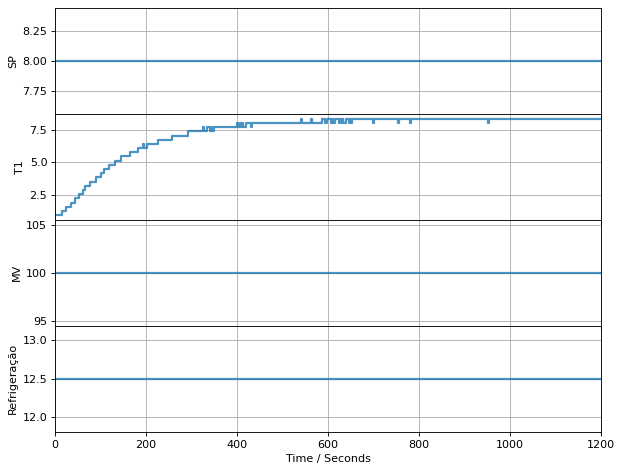

TCLab Model disconnected successfully.


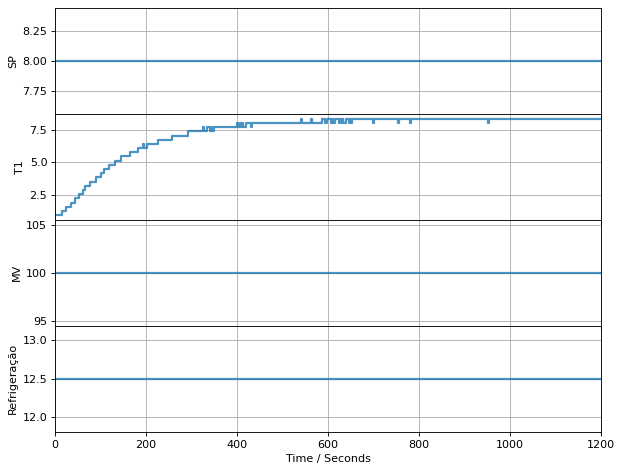

In [7]:
TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP = 8
controllerTEMP = PID(2, 1.5, 2.5)
controllerTEMP.send(None)

# Periodo de simulação de 2 horas:
tfinal = 1200

lab.U1 = 100
lab.Q1(0)

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: PV_TEMP),
                  ('MV', lambda: MV_TEMP), ('Refrigeração', lab.Q1)])

    p = Plotter(h, tfinal)
    T1 = lab.T1

    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = SetPointTEMP
        PV_TEMP = lab.T1 - 20
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP/8

        p.update(t)

### 6 - Fermentação:

Etapa em que a levedura é adicionada ao mosto lupulado, favorecendo a transformação dos açúcares em álcool e dióxido de carbono, durante um período de aproximadamente sete dias.

<span style="color:orange">Primeiro Setpoint da Temperatura de Fermentação será de 25 °C </span>

<span style="color:orange">Segundo Setpoint da Temperatura de Fermentação será de 15 °C </span>

<span style="color:yellow">Setpoint de pH será de 5,5 </span>

`O valor de 2500 associado à variável tfinal visa simular 7 dias`

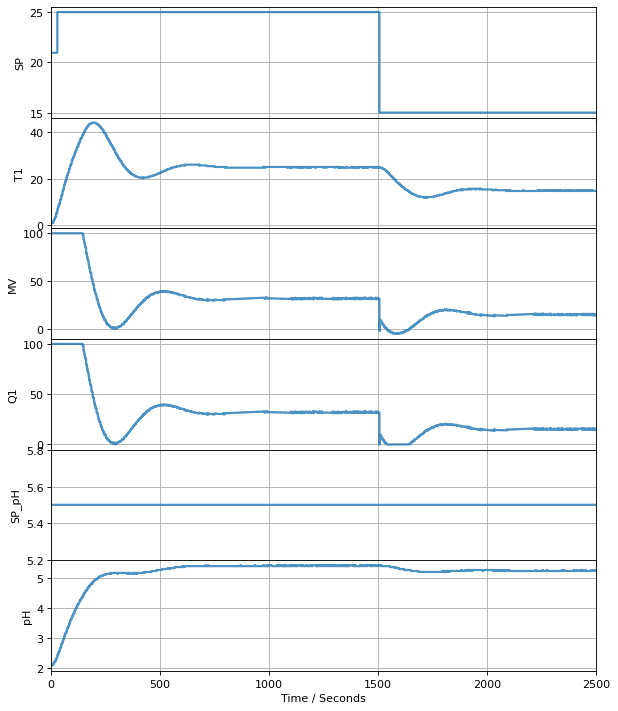

TCLab Model disconnected successfully.

Passados o período de 7 dias



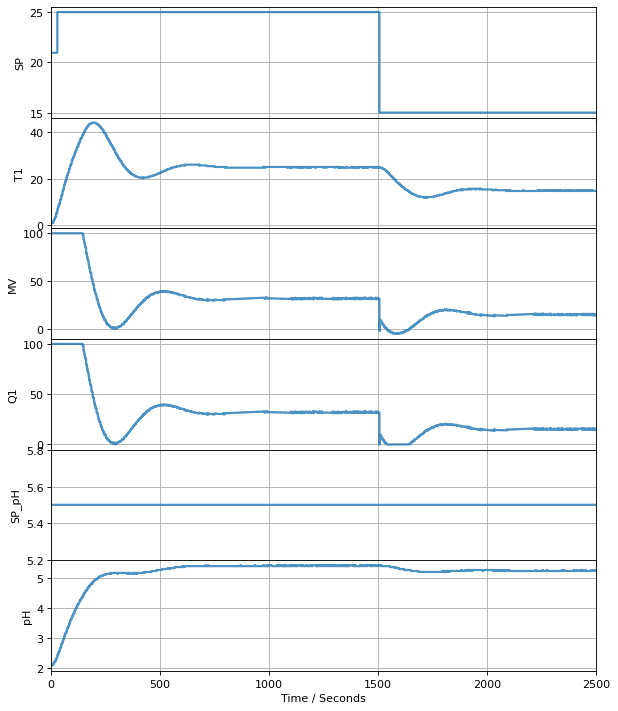

In [8]:
# Período de 7 dias:
print('\nPeríodo de 7 dias\n')

TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP1 = 25
SetPointTEMP2 = 15
t_degrau = 1500

SetPointTEMP = SetPointTEMP1

controllerTEMP = PID(2, 0.05, 2.5)
controllerTEMP.send(None)

# Parâmetros do controle de pH:
# Convenientemente, para fins de simulação iremos empregar o T2 como uma entrada simulada de sensor de pH que já possui uma resposta inercial descrita.
SetPoint_pH = 5.5
controller_pH = PID(1, 0.1, 2.0)
controller_pH.send(None)

# Periodo de simulação:
tfinal = 2500  # 7 dias de Fermentação

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: lab.T1 - 20), ('MV', lambda: MV_TEMP), ('Q1', lab.Q1),
                   ('SP_pH', lambda: SP_ph/10), ('pH', lambda: lab.T2/10)])

    p = Plotter(h, tfinal)
    T1 = lab.T1
    T2 = lab.T2
    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = T1 if t < SetPointTEMP else SetPointTEMP
        PV_TEMP = lab.T1 - 20
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP
        # programação do degrau:
        if t > t_degrau:
            SetPointTEMP = SetPointTEMP2

        # Controle de pH:
        SP_ph = (SetPoint_pH * 10)
        PV_ph = lab.T2
        MV_ph = controller_pH.send([t, PV_ph, SP_ph])
        lab.U2 = MV_ph

        p.update(t)

# Período de 7 dias:
print('\nPassados o período de 7 dias\n')

### 7 - Maturação e filtração: 

A cerveja é novamente filtrada para a retirada de resquícios da levedura e de outros componentes que possam ainda estar presentes, e em seguida é levemente aquecida novamente, para a eliminação de componentes voláteis, que não o álcool.

Existem muitas discussões sobre o ciclo desta fase, bem como inúmeras receitas diferentes visando produtos finais distintos.

No presente exemplo, iremos iniciar com a `Filtragem` para depois prosseguir com a maturação.

Para essa simulação iremos focar no controle de temperatura fazendo referência a um período de `10 dias`.

<span style="color:orange">Primeiro Setpoint da Temperatura de Fermentação será de 1 °C </span>

<span style="color:orange">Segundo Setpoint da Temperatura de Fermentação será de 5 °C </span>


In [9]:
# Filtragem com medição de densidade:

env = simpy.Environment()
dens = Densimetro(env)
env.process(sim_Densimetro(env, dens))
env.run(until=100)

Aguardando 3 horas para medir densidade 0
Densidade do mosto está ideal ...


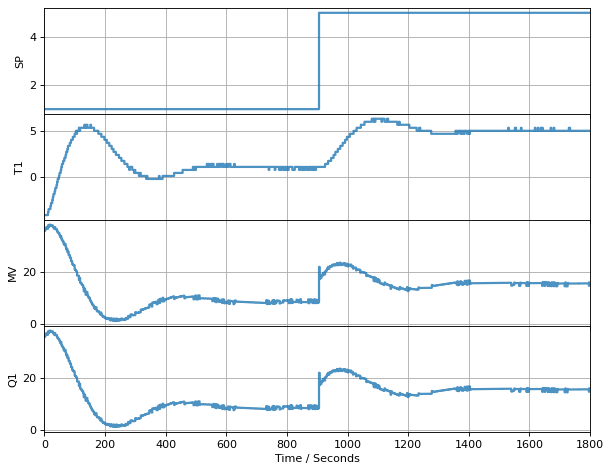

TCLab Model disconnected successfully.

Passados o período de 10 dias



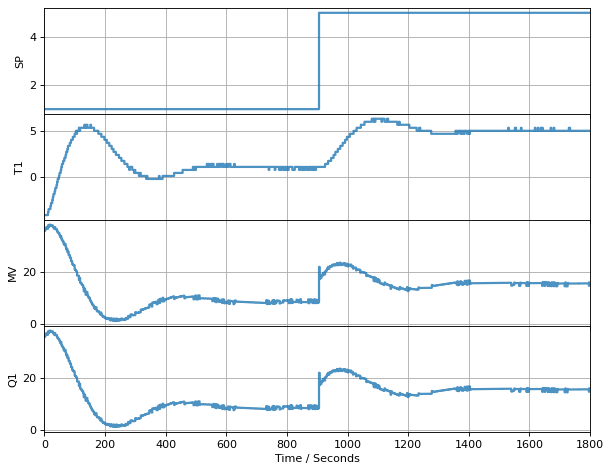

In [10]:
# Período de 10 dias:
print('\nPeríodo de 10 dias\n')

TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP1 = 1
SetPointTEMP2 = 5
t_degrau = 900

SetPointTEMP = SetPointTEMP1

controllerTEMP = PID(2, 0.05, 2.5)
controllerTEMP.send(None)

# Periodo de simulação:
tfinal = 1800  # 7 dias de Fermentação

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: lab.T1 - 25),
                  ('MV', lambda: MV_TEMP), ('Q1', lab.Q1)])

    p = Plotter(h, tfinal)
    T1 = lab.T1
    T2 = lab.T2
    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = SetPointTEMP
        PV_TEMP = lab.T1 - 25
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP
        # programação do degrau:
        if t > t_degrau:
            SetPointTEMP = SetPointTEMP2

        p.update(t)

# Período de 10 dias:
print('\nPassados o período de 10 dias\n')

### 8 - Estabilização: 

Após o novo aquecimento da etapa anterior, a cerveja também é submetida um segundo resfriamento, agora em temperatura em torno de 0 ºC e 2 ºC, para uma melhor fixação das propriedades da cerveja.

Para essa simulação iremos focar no controle de temperatura fazendo referência a um período de `2 dias`.

<span style="color:orange">Setpoint da Temperatura de Estabilização será de 1 °C </span>


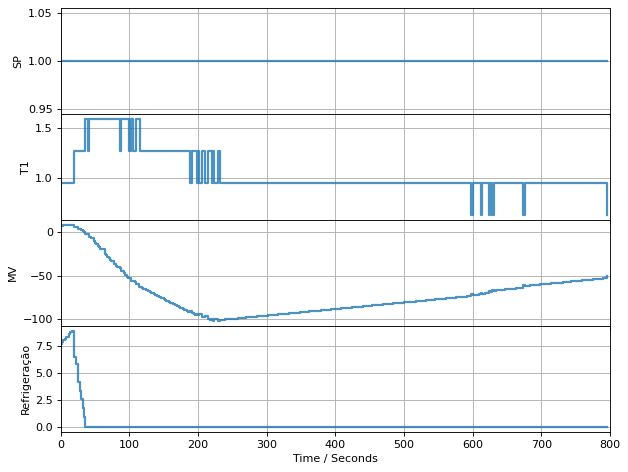

TCLab Model disconnected successfully.

Passados o período de 2 dias



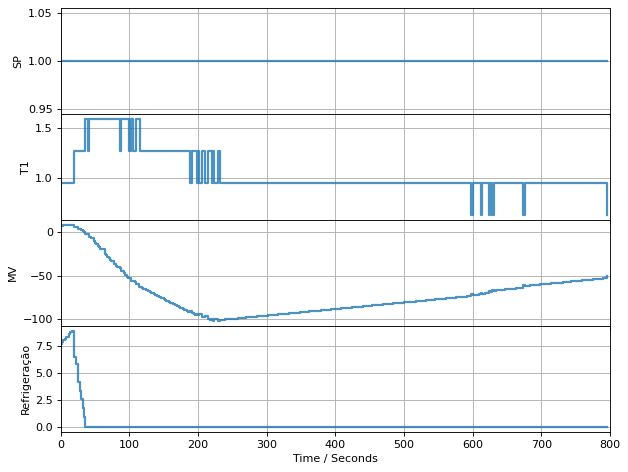

In [11]:
TCLab = setup(connected=False, speedup=10)

# Parâmetros do controle de Temperatura:
SetPointTEMP = 1
controllerTEMP = PID(2, 1.5, 2.5)
controllerTEMP.send(None)

# Periodo de simulação de 2 horas:
tfinal = 800

lab.U1 = 10
lab.Q1(0)

with TCLab() as lab:
    h = Historian([('SP', lambda: SP_TEMP), ('T1', lambda: PV_TEMP),
                  ('MV', lambda: MV_TEMP), ('Refrigeração', lab.Q1)])

    p = Plotter(h, tfinal)
    T1 = lab.T1

    for t in clock(tfinal, 2):
        # Controle de temperatura:
        SP_TEMP = SetPointTEMP
        PV_TEMP = lab.T1 - 20
        MV_TEMP = controllerTEMP.send([t, PV_TEMP, SP_TEMP])
        lab.U1 = MV_TEMP/1

        p.update(t)

# Período de 2 dias:
print('\nPassados o período de 2 dias\n')

### 9 - Clarificação: 

Depois de estabilizada, a cerveja é submetida a uma última filtração, para a eliminação de qualquer partícula restante em suspensão. Logo em seguida, é armazenada em tanques.

Para essa simulação iremos focar no controle da `densidade` novamente, que é o procedimento comumente indicado em processos semi-industriais.

A temperatura será mantida a ambiente.


In [12]:
# Filtragem com medição de densidade:

env = simpy.Environment()
dens = Densimetro(env)
env.process(sim_Densimetro(env, dens))
env.run(until=100)

Aguardando 3 horas para medir densidade 0
Densidade do mosto está ideal ...


### 10 - Enchimento ou Envase: 

Nesta última etapa do processo de produção, a cerveja será envasada, por exemplo, em garrafas ou latas.

Dentro das descrições encontradas, o processo consiste de um vaso de pressão mantido a pressão constante com um dosador que controla a vazão para os recipientes de `350 mL`

Existem recomendações para que isso ocorra em temperatura atmosférica visando acelerar a perda de CO2, mas também a receitas indicando a manutenção da cerveja em baixa temperatura e acompanhado de pressurização de CO2.

Será necessário verificar a receita do cliente.

<span style="color:yellow">Atenção: </span> Nesta simulação iremos usar um sistema passivo que consiste de um [`cilindro pressurizado de CO2`](https://www.lojabrasilfire.com.br/extintores/cilindro-de-co2-cheio-para-chopeira-e-aquario) com qualidade de pureza apropriada para bebidas e uma [`válvula reguladora de pressão`](https://www.cervejadacasa.com/embarrilamento/valvula-reguladora-de-pressao-c-duas-saidas-c-manometro).

In [15]:
def dosador(env, moinho):
    yield env.timeout(350)
    # Aqui estamos simulando o ponto em que o sensor MYTA irá indicar a granulometria esperada
    # Usamos neste caso como uma função do tempo, mas no caso real, teremos um valor de granulometria que irá influenciar no processo.
    moinho.action.interrupt()


class Envase(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.dosagem())

    def dosagem(self):
        while True:
            print('Volume contabilizado: %d mL' % self.env.now)
            tempo_de_moagem = 10

            try:
                yield self.env.process(self.aguardar(tempo_de_moagem))
            except simpy.Interrupt:
                # print('Recimente com volume completo! Próximo...')
                print('Recimente com volume de %d mL completo! Próximo... ' %
                      self.env.now)
                # PARAR AQUI
                return

    def aguardar(self, duracao):
        yield self.env.timeout(duracao)


env = simpy.Environment()
envase = Envase(env)
env.process(dosador(env, envase))
env.run(until=500)

Volume contabilizado: 0 mL
Volume contabilizado: 10 mL
Volume contabilizado: 20 mL
Volume contabilizado: 30 mL
Volume contabilizado: 40 mL
Volume contabilizado: 50 mL
Volume contabilizado: 60 mL
Volume contabilizado: 70 mL
Volume contabilizado: 80 mL
Volume contabilizado: 90 mL
Volume contabilizado: 100 mL
Volume contabilizado: 110 mL
Volume contabilizado: 120 mL
Volume contabilizado: 130 mL
Volume contabilizado: 140 mL
Volume contabilizado: 150 mL
Volume contabilizado: 160 mL
Volume contabilizado: 170 mL
Volume contabilizado: 180 mL
Volume contabilizado: 190 mL
Volume contabilizado: 200 mL
Volume contabilizado: 210 mL
Volume contabilizado: 220 mL
Volume contabilizado: 230 mL
Volume contabilizado: 240 mL
Volume contabilizado: 250 mL
Volume contabilizado: 260 mL
Volume contabilizado: 270 mL
Volume contabilizado: 280 mL
Volume contabilizado: 290 mL
Volume contabilizado: 300 mL
Volume contabilizado: 310 mL
Volume contabilizado: 320 mL
Volume contabilizado: 330 mL
Volume contabilizado: 340